## <p style="text-align: center;">Исследование аномалий в multivariate time-series при помощи вариационных автокодировщиков на базе TCN и трансформеров</p>

### План работы: 

1. Построение и обучение вариационного автокодировщика на базе: 
- линейной модели
- модели на базе TCN (Temporal Convolution Network - имплементация из библиотеки [Darts](https://github.com/unit8co/darts#installation-guide))
- транфсорфмеров (из PyTorch)
2. Обучение модеели VAE на fault free (healthy) data. Подбор гиперпараметров.
3. Выявление аномалий и составление датасета для классификации аномалий по маркированному датасету.
4. Подсчет метри Precision и Recall для тестового датасета в задаче классификации аномалий.
5. Выводы, сравнение с бенчмарками.

Данные:
[Additional Tennessee Eastman Process Simulation Data for Anomaly Detection Evaluation](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/6C3JR1)

In [18]:
!pip install pyreadr

In [19]:
from itertools import chain
import requests
import pandas as pd
import numpy as np
import pyreadr
import torch
from torch import nn
from torch.optim import Adam
from torch.nn import MSELoss
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tqdm.notebook import tqdm 
from IPython.display import clear_output

import matplotlib.pyplot as plt

In [20]:
open('tcn_model.py', 'w').write(requests.get('https://raw.githubusercontent.com/AlexShevchuk7/MADE/master/Diploma/tcn_model.py').text)
open('TEP_FaultFree_Training.RData', 'wb').write(requests.get('https://github.com/AlexShevchuk7/MADE/blob/master/Diploma/TEP_FaultFree_Training.RData?raw=true').content)


24678017

In [21]:
from tcn_model import TCNModel

In [22]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [23]:
class TSDataset(Dataset):
    def __init__(self, data, window, offset):
        self.data = torch.tensor(data, dtype=torch.float).to(device)
        self.window = window
        self.offset = offset
        self.shape = self.__getshape__()
        self.size = self.__getsize__()
 
    def __getitem__(self, index):
        x = self.data[index : index + self.window]
        return x
 
    def __len__(self):
        return len(self.data) -  self.window 
    
    def __getshape__(self):
        return (self.__len__(), *self.__getitem__(0)[0].shape)
    
    def __getsize__(self):
        return (self.__len__())

In [24]:
class Basic_net(nn.Module):
    def __init__(self, batch, hidden_dim=512):
        super(Basic_net, self).__init__()
        self.hidden_dim = hidden_dim
        input_dim = batch.shape[1]*batch.shape[2]
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim , hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.model(x)
        return torch.reshape(x, (-1, batch.shape[1], self.hidden_dim // batch.shape[1]))

In [25]:
class LinearEncoder(nn.Module):
    def __init__(self, input_dim, latent_dim=16):
        super(LinearEncoder, self).__init__()        
        self.embedding = Basic_net(batch)
        
        self.hidden_dim = input_dim.shape[1] * input_dim.shape[2]
        self.mu = nn.Linear(self.hidden_dim, latent_dim)
        self.sigma = nn.Linear(self.hidden_dim, latent_dim)
    
    def forward(self, x):
        embedding = self.embedding(x)
        flat_embedding = torch.flatten(embedding, start_dim=1)
        
        mu = F.relu(self.mu(flat_embedding))
        logsigma = F.relu(self.sigma(flat_embedding))
        
        return mu, logsigma

In [ ]:
class TCNEncoder(nn.Module):
    def __init__(self, batch, tcn, latent_dim=16):
        super(TCNEncoder, self).__init__()
        self.embedding = tcn._create_model(batch).to(device)
        
        self.hidden_dim = batch.shape[1] * batch.shape[2]
        self.mu = nn.Linear(self.hidden_dim, latent_dim)
        self.sigma = nn.Linear(self.hidden_dim, latent_dim)
    
    def forward(self, x):
        embedding = self.embedding(x)
        flat_embedding = torch.flatten(embedding, start_dim=1)
        
        mu = F.relu(self.mu(flat_embedding))
        logsigma = F.relu(self.sigma(flat_embedding))
        
        return mu, logsigma

In [ ]:
class TransformEncoder(nn.Module):
    def __init__(self, batch, latent_dim=16):
        super(TransformEncoder, self).__init__()
        
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=52, nhead=4, dim_feedforward=256)
        self.transformer = nn.modules.TransformerEncoder(self.encoder_layer, num_layers=8)
                             
        self.hidden_dim = batch.shape[1] * batch.shape[2]
        self.mu = nn.Linear(self.hidden_dim, latent_dim)
        self.sigma = nn.Linear(self.hidden_dim, latent_dim)
    
    def forward(self, x):
        embedding = self.transformer(x)
        flat_embedding = torch.flatten(embedding, start_dim=1)
        
        mu = F.relu(self.mu(flat_embedding))
        logsigma = F.relu(self.sigma(flat_embedding))
        
        return mu, logsigma

In [ ]:
class SimpleDecoder(nn.Module):
    def __init__(self, batch_shape, latent_dim):
        super(Decoder, self).__init__()
        self.batch_dim = batch_shape[0]
        self.chunk_length = batch_shape[1]
        self.latent_dim = latent_dim
        self.chunk_size = batch_shape[2]
        self.lin1 = nn.Linear(self.latent_dim, self.chunk_length)
        self.lin2 = nn.Linear(self.chunk_length, self.chunk_length * self.chunk_size)
        
    def forward(self, x):
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        return torch.reshape(x, (self.batch_dim, self.chunk_length, self.chunk_size))

In [26]:
class Decoder(nn.Module):
    def __init__(self, batch_shape, latent_dim):
        super(Decoder, self).__init__()
        self.batch_dim = batch_shape[0]
        self.chunk_length = batch_shape[1]
        self.latent_dim = latent_dim
        self.chunk_size = batch_shape[2]
        self.fc1 = nn.Linear(self.latent_dim, self.chunk_length * 4)
        self.fc2 = nn.Linear(self.chunk_length * 4, self.chunk_length * 4)
        #self.batchnorm1 = nn.BatchNorm1d(self.chunk_length * 4)
        self.fc3 = nn.Linear(self.chunk_length * 4, self.chunk_length * 2)
        self.fc4 = nn.Linear(self.chunk_length * 2, self.chunk_length * self.chunk_size)
        #self.batchnorm2 = nn.BatchNorm1d(self.chunk_length * self.chunk_size)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        #x = self.batchnorm2(x)
    
        return torch.reshape(x, (-1, self.chunk_length, self.chunk_size))

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, batch_shape):
        super(Autoencoder, self).__init__()
        self.hidden_dim = batch.shape[1] * batch.shape[2]
        self.batch_shape = batch_shape
        self.latent_dim = 32
        #self.embedding = Basic_net()
        self.embedding = tcn._create_model(batch)
        self.encoder = nn.Linear(self.hidden_dim, self.latent_dim)
        
        self.decoder1 = nn.Linear(self.latent_dim, batch_shape[1])
        self.decoder2 = nn.Linear(batch_shape[1], batch_shape[1] * 3)
        
    def forward(self, x):
        enc = self.embedding(x)
        flat_embedding = torch.flatten(enc, start_dim=1)
        enc = F.relu(self.encoder(flat_embedding))
        
        dec = F.relu(self.decoder1(enc))
        dec = F.relu(self.decoder2(dec))
        
        return torch.reshape(dec, (self.batch_shape[0], self.batch_shape[1], self.batch_shape[2]))

In [27]:
class VAE(nn.Module):
    def __init__(self, encoder, decoder, device=device):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        self.mu = None
        self.std = None
        
    def sample_z(self, mu, std):
        epsilon = torch.randn(mu.size())
        epsilon = Variable(epsilon, requires_grad=False).type(torch.FloatTensor).to(self.device)
        z = mu + std * epsilon
        return z
    
    def forward(self, x):
        self.mu, logvar = self.encoder(x)
        self.std = torch.exp(0.5 * logvar)
        z = self.sample_z(self.mu.to(self.device), self.std.to(self.device))
        decoder_out = self.decoder(z)
        return decoder_out, self.mu, logvar

In [ ]:
# TODO: написать класс для построения эмбеддингов на базе трансформеров (взять из pytorch)

### Считывание данных. Формирование dataloader

In [28]:
train_data = pyreadr.read_r('TEP_FaultFree_Training.RData')

In [29]:
for items in train_data.items():
    tsdata = items[1]

In [ ]:
tsdata.head()

,faultNumber,simulationRun,sample,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,xmeas_7,xmeas_8,xmeas_9,xmeas_10,xmeas_11,xmeas_12,xmeas_13,xmeas_14,xmeas_15,xmeas_16,xmeas_17,xmeas_18,xmeas_19,xmeas_20,xmeas_21,xmeas_22,xmeas_23,xmeas_24,xmeas_25,xmeas_26,xmeas_27,xmeas_28,xmeas_29,xmeas_30,xmeas_31,xmeas_32,xmeas_33,xmeas_34,xmeas_35,xmeas_36,xmeas_37,xmeas_38,xmeas_39,xmeas_40,xmeas_41,xmv_1,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
0,0.0,1.0,1,0.25038,3674.0,4529.0,9.2320,26.889,42.402,2704.3,74.863,120.41,0.33818,80.044,51.435,2632.9,25.029,50.528,3101.1,22.819,65.732,229.61,341.22,94.640,77.047,32.188,8.8933,26.383,6.8820,18.776,1.6567,32.958,13.823,23.978,1.2565,18.579,2.2633,4.8436,2.2986,0.017866,0.8357,0.098577,53.724,43.828,62.881,53.744,24.657,62.544,22.137,39.935,42.323,47.757,47.510,41.258,18.447
1,0.0,1.0,2,0.25109,3659.4,4556.6,9.4264,26.721,42.576,2705.0,75.000,120.41,0.33620,80.078,50.154,2633.8,24.419,48.772,3102.0,23.333,65.716,230.54,341.30,94.595,77.434,32.188,8.8933,26.383,6.8820,18.776,1.6567,32.958,13.823,23.978,1.2565,18.579,2.2633,4.8436,2.2986,0.017866,0.8357,0.098577,53.724,43.828,63.132,53.414,24.588,59.259,22.084,40.176,38.554,43.692,47.427,41.359,17.194
2,0.0,1.0,3,0.25038,3660.3,4477.8,9.4426,26.875,42.070,2706.2,74.771,120.42,0.33563,80.220,50.302,2635.5,25.244,50.071,3103.5,21.924,65.732,230.08,341.38,94.605,77.466,31.767,8.7694,26.095,6.8259,18.961,1.6292,32.985,13.742,23.897,1.3001,18.765,2.2602,4.8543,2.3900,0.017866,0.8357,0.098577,53.724,43.828,63.117,54.357,24.666,61.275,22.380,40.244,38.990,46.699,47.468,41.199,20.530
3,0.0,1.0,4,0.24977,3661.3,4512.1,9.4776,26.758,42.063,2707.2,75.224,120.39,0.33553,80.305,49.990,2635.6,23.268,50.435,3102.8,22.948,65.781,227.91,341.71,94.473,77.443,31.767,8.7694,26.095,6.8259,18.961,1.6292,32.985,13.742,23.897,1.3001,18.765,2.2602,4.8543,2.3900,0.017866,0.8357,0.098577,53.724,43.828,63.100,53.946,24.725,59.856,22.277,40.257,38.072,47.541,47.658,41.643,18.089
4,0.0,1.0,5,0.29405,3679.0,4497.0,9.3381,26.889,42.650,2705.1,75.388,120.39,0.32632,80.064,51.310,2632.4,26.099,50.480,3103.5,22.808,65.788,231.37,341.11,94.678,76.947,32.322,8.5821,26.769,6.8688,18.782,1.6396,33.071,13.834,24.228,1.0938,18.666,2.2193,4.8304,2.2416,0.017866,0.8357,0.098577,53.724,43.828,63.313,53.658,28.797,60.717,21.947,39.144,41.955,47.645,47.346,41.507,18.461


In [ ]:
tsdata.shape

(250000, 55)

In [ ]:
tsdata.iloc[:100000, 3:].shape

(100000, 52)

In [30]:
scaler = StandardScaler()
minmax = MinMaxScaler()

#data = tsdata[['xmeas_1', 'xmeas_2', 'xmeas_3']][:100000]
signal = tsdata.iloc[:, 3:] 
# TODO: провести обучение на полном датасете (сокращение обусловлено ускорением настройки кодировщиков)
#scaled_data = scaler.fit_transform(signal)
mm_signal = minmax.fit_transform(signal)

In [31]:
batch_size = 64
window = 64
lag = 4

def batch_sampler():
    idx = [i * lag for i in range(len(data) // lag)]
    batch_size = 16
    curs = 0
    
    while curs < len(idx) - batch_size:
        batch = idx[curs : curs + batch_size]
        curs += batch_size
        yield batch
        

dataset = TSDataset(mm_signal, window, 1)

trainloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)#, batch_sampler=batch_sampler())


In [32]:
# Первый батч потребуется для конфигурирования архитектур сетей энкодера / декодера
for batch in trainloader:
    break

In [ ]:
batch[0]

tensor([[0.4871, 0.5535, 0.5502,  ..., 0.4486, 0.5512, 0.5018],
        [0.4898, 0.5021, 0.6374,  ..., 0.4448, 0.5720, 0.4030],
        [0.4871, 0.5053, 0.3885,  ..., 0.4467, 0.5390, 0.6661],
        ...,
        [0.4678, 0.2495, 0.3961,  ..., 0.6326, 0.4264, 0.3761],
        [0.4266, 0.4120, 0.4630,  ..., 0.6232, 0.3523, 0.4931],
        [0.4253, 0.3346, 0.3793,  ..., 0.6251, 0.2869, 0.3150]])

#### Пример формирования TCN-модели

In [ ]:
tcn = TCNModel(num_filters=20, input_chunk_length=window, output_chunk_length=50)

In [ ]:
tcn_net = tcn._create_model(batch)

In [ ]:
tcn_net = tcn_net.to(device)

In [ ]:
tcn_output = tcn_net(batch)

In [ ]:
tcn_output.shape

torch.Size([16, 64, 3])

In [ ]:
batch.shape

torch.Size([16, 64, 3])

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### Обучение модели обычного автокодировщика

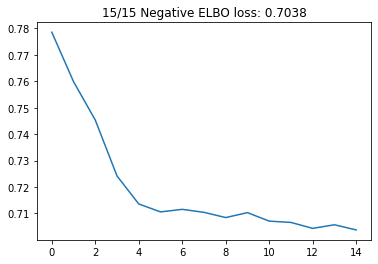

In [ ]:
loss_vals = []
n_epochs = 15
autoencoder = Autoencoder(batch.shape)
opt = Adam(autoencoder.parameters(), lr=0.0001)
mse = MSELoss()

for i in tqdm(range(n_epochs)):
    for batch in trainloader:
        opt.zero_grad()
        
        reconstruction = autoencoder(batch)
        rec_loss = mse(reconstruction, batch)
       
        rec_loss.backward()
        opt.step()

    loss_vals.append(rec_loss.item())

        #if i % 100 == 0:
    plt.plot(loss_vals[-100:])
    plt.title('{}/{} Negative ELBO loss: {:.4f}'.format(i+1, n_epochs, loss_vals[-1]))
    plt.show();
    clear_output(wait=True)

### Обучение вариационного автокодировщика на данных без аномалий

#### (настройка гиперпараметров автокодировщика производится по эмбеддингам линейной модели)

In [22]:
kl_loss

tensor(-0., device='cuda:0', grad_fn=<DivBackward0>)

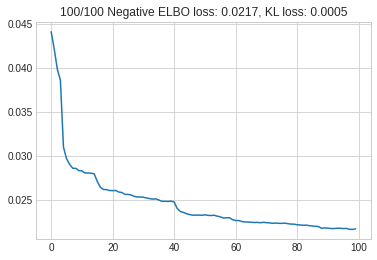

In [35]:
kldivs = []
mses = []
loss_vals = []
n_epochs = 100
latent_dim = 16
#tcn_net = TCNModel(num_filters=20, kernel_size=5, input_chunk_length=window, output_chunk_length=50)
basic_emb = Basic_net(batch).to(device)
embedded = basic_emb(batch)
encoder = LinearEncoder(embedded)
encoder = encoder.to(device)
#encoder = TCNEncoder(batch, tcn_net)
decoder = Decoder(batch.shape, latent_dim).to(device)
#decoder = decoder.to(device)
vae = VAE(encoder, decoder)
vae = vae.to(device)
criterion = nn.MSELoss()
opt = Adam(vae.parameters(), lr=0.0002)
mse = MSELoss()
beta = 0.5

for i in tqdm(range(n_epochs)):
    for b_n, batch in enumerate(trainloader):        
        opt.zero_grad()
        
        logits, mu, logvar = vae(batch)

        reconstruction_loss = mse(logits, batch)
        #lk_loss = beta * (1 + torch.log(sigma**2) - mu**2 - sigma**2) * 0.5 /  (batch.shape[0] * batch.shape[1] * batch.shape[2])
        #l_kl = l_kl.sum(1).mean()
        kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - 
                                   logvar.exp(), -1).mean() / (batch.shape[0] * batch.shape[1] * batch.shape[2]) * beta
        loss = reconstruction_loss + kl_loss
        
        loss.sum().backward()
        opt.step()

    mses.append(reconstruction_loss)
    kldivs.append(kl_loss)
    loss_vals.append(loss.item())

        #if i % 100 == 0:
    plt.plot(loss_vals[-100:])
    plt.title('{}/{} Negative ELBO loss: {:.4f}, KL loss: {:.4f}'.format(i+1, n_epochs, loss_vals[-1], kl_loss))
    plt.show();
    clear_output(wait=True)

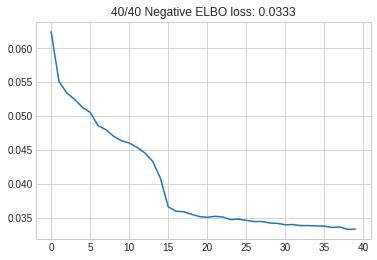

In [ ]:
kldivs = []
mses = []
loss_vals = []
n_epochs = 40
latent_dim = 16

#tcn_net = TCNModel(num_filters=20, kernel_size=5, input_chunk_length=window, output_chunk_length=50)
#encoder = TCNEncoder(batch, tcn_net)

encoder = TransformEncoder(batch).to(device)

decoder = Decoder(batch.shape, latent_dim).to(device)

vae = VAE(encoder, decoder)
vae = vae.to(device)
criterion = nn.MSELoss()
opt = Adam(vae.parameters(), lr=0.0001)
mse = MSELoss()
beta = 1

for i in tqdm(range(n_epochs)):
    for b_n, batch in enumerate(trainloader):
        #beta += min(1, i / 20)
        #beta = 1.2
        
        opt.zero_grad()
        
        logits, mu, sigma = vae(batch)

        l_rec = mse(logits, batch)
        l_kl = beta * (1 + torch.log(sigma**2) - mu**2 - sigma**2) * 0.5 / (batch.shape[0] * batch.shape[1] * batch.shape[2])
        l_kl = l_kl.sum(1).mean()
        loss = l_rec - l_kl
        
        loss.backward()
        opt.step()

    mses.append(l_rec)
    kldivs.append(-l_kl)
    loss_vals.append(loss.item())

        #if i % 100 == 0:
    plt.plot(loss_vals[-100:])
    plt.title('{}/{} Negative ELBO loss: {:.4f}'.format(i+1, n_epochs, loss_vals[-1]))
    plt.show();
    clear_output(wait=True)

#### Построение графиков reconstruction error и KL-divergence

Text(0.5, 0, 'epochs')

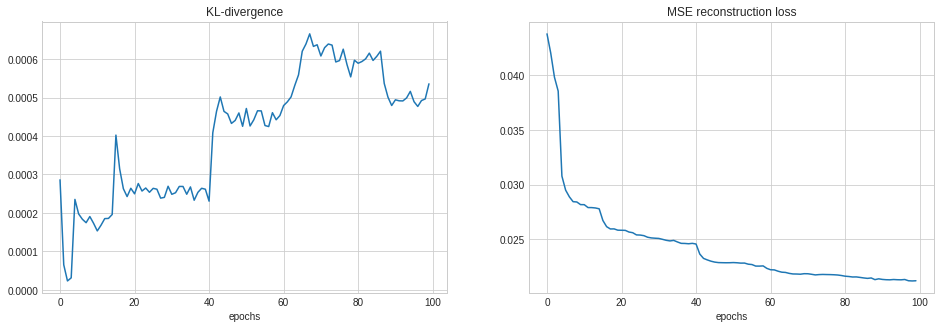

In [36]:
plt.figure(figsize=(16, 5))
plt.style.use('seaborn-whitegrid')

plt.subplot(1, 2, 1)
plt.title("KL-divergence")
plt.xlabel("epochs")
plt.plot(kldivs)

plt.subplot(1, 2, 2)
plt.plot(mses)
plt.title("MSE reconstruction loss")
plt.xlabel("epochs")


In [37]:
torch.save(vae.state_dict(), 'mlp_e100_lr2e-4_b64_beta05.pkl')

In [32]:
1 + 1

2

In [ ]:
# TODO: обучить VAE на базе TCN, подобрать архитектуру TCN и гиперпараметры

In [ ]:
# TODO: обучить VAE на базе трансформеров, подобрать архитектуру и гиперпараметры

### Тестирование на данных с аномалиями

In [ ]:
test_data = pyreadr.read_r('data/TEP_Faulty_Training.RData')

In [ ]:
for items in test_data.items():
    testdata = items[1]

In [ ]:
testdata.head()

,faultNumber,simulationRun,sample,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,xmeas_7,...,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
0,1,1.0,1,0.25038,3674.0,4529.0,9.2320,26.889,42.402,2704.3,...,53.744,24.657,62.544,22.137,39.935,42.323,47.757,47.510,41.258,18.447
1,1,1.0,2,0.25109,3659.4,4556.6,9.4264,26.721,42.576,2705.0,...,53.414,24.588,59.259,22.084,40.176,38.554,43.692,47.427,41.359,17.194
2,1,1.0,3,0.25038,3660.3,4477.8,9.4426,26.875,42.070,2706.2,...,54.357,24.666,61.275,22.380,40.244,38.990,46.699,47.468,41.199,20.530
3,1,1.0,4,0.24977,3661.3,4512.1,9.4776,26.758,42.063,2707.2,...,53.946,24.725,59.856,22.277,40.257,38.072,47.541,47.658,41.643,18.089
4,1,1.0,5,0.29405,3679.0,4497.0,9.3381,26.889,42.650,2705.1,...,53.658,28.797,60.717,21.947,39.144,41.955,47.645,47.346,41.507,18.461


In [ ]:
testdata.shape

(5000000, 55)

In [ ]:
# Количество типов анломалий: 
testdata["faultNumber"].nunique()

20

In [ ]:
data = testdata[['xmeas_1', 'xmeas_2', 'xmeas_3']].iloc[:100000] ### !!!
# TODO: провести тестирование на полном датасете (сокращение обусловлено ускорением настройки кодировщиков)
scaled_test = scaler.fit_transform(data)

In [ ]:
dataset = TSDataset(scaled_test, window, 2)

testloader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=False)

In [ ]:
vae = VAE(encoder, decoder)

### Выявление аномалий через вычисление ошибки реконструкции сигнала

In [ ]:
def reconstruction_loss(reconstructed_batch, batch, mu, sigma):
    l_rec = mse(reconstructed_batch, batch)
    l_kl = beta * (1 + torch.log(sigma**2) - mu**2 - sigma**2) * 0.5 / (batch.shape[1] * batch.shape[2])
    l_kl = l_kl.sum(1).mean()
    loss = l_rec - l_kl
    
    return loss

In [ ]:
vae.eval()
test_loss = []

for test_batch in testloader:
    
    with torch.no_grad():
        reconstructed_batch, mu, sigma = vae(test_batch)
        loss = reconstruction_loss(reconstructed_batch, test_batch, mu, sigma).item()
    
    test_loss.append(loss)

#### Визуализация обнаружения аномалий

In [ ]:
# Уровень ошибки неаномального поведения:
healthy_loss = mses[-1] + kldivs[-1]
healthy_loss.item()

0.6664955019950867

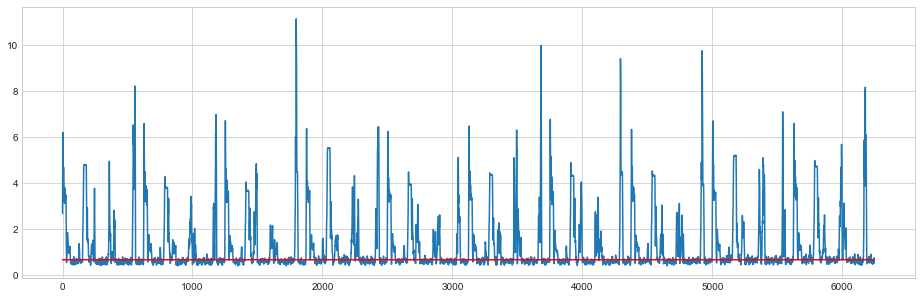

In [ ]:
plt.figure(figsize=(16, 5))
plt.plot(test_loss)

healthy_level = healthy_loss.item() * np.ones((len(test_loss), ))
plt.plot(healthy_level, color='red')

In [ ]:
# TODO: опробовать метод подсчета через подсчет likelihood
# TODO: классификация аномалий (многоклассовая)
# TODO: подсчет метрик recall и precision